In [2]:
from py import nets, ce
import torch
from py.utils import get_default_device, imshow
from py.train import train_mnist, test, test_on_attack
from torchattacks import *
from py.attacks import get_attacks
from torch import optim
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from py.train import train_mnist, train_with_validation, test
from py.nets import CIFARModel
from py import utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np
import os
import requests
from py.utils import download_url

import matplotlib.pyplot as plt
%matplotlib inline

variabilities = [0.1, 0.0015, 0.002, 0.005, 0.01]

MEAN = [0.49139968, 0.48215841, 0.44653091]
STD  = [0.24703223, 0.24348513, 0.26158784]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

n_epochs = 30
batch_size = 64
learning_rate = 0.01
momentum = 0.9
num_workers=4

url = "https://zenodo.org/record/2535967/files/CIFAR-10-C.tar"
target_path = './datasets/CIFAR-10-C-tar'

import tarfile

# Download the datasets. WARNING:2GB download

In [3]:
# Download the data

if (os.path.exists("./datasets/CIFAR-10-C/") != True):
    download_url(url, target_path)
    with tarfile.open(target_path) as tar:
        tar.extractall(path="./datasets")
    os.remove(target_path)

# Display labelled images

Files already downloaded and verified


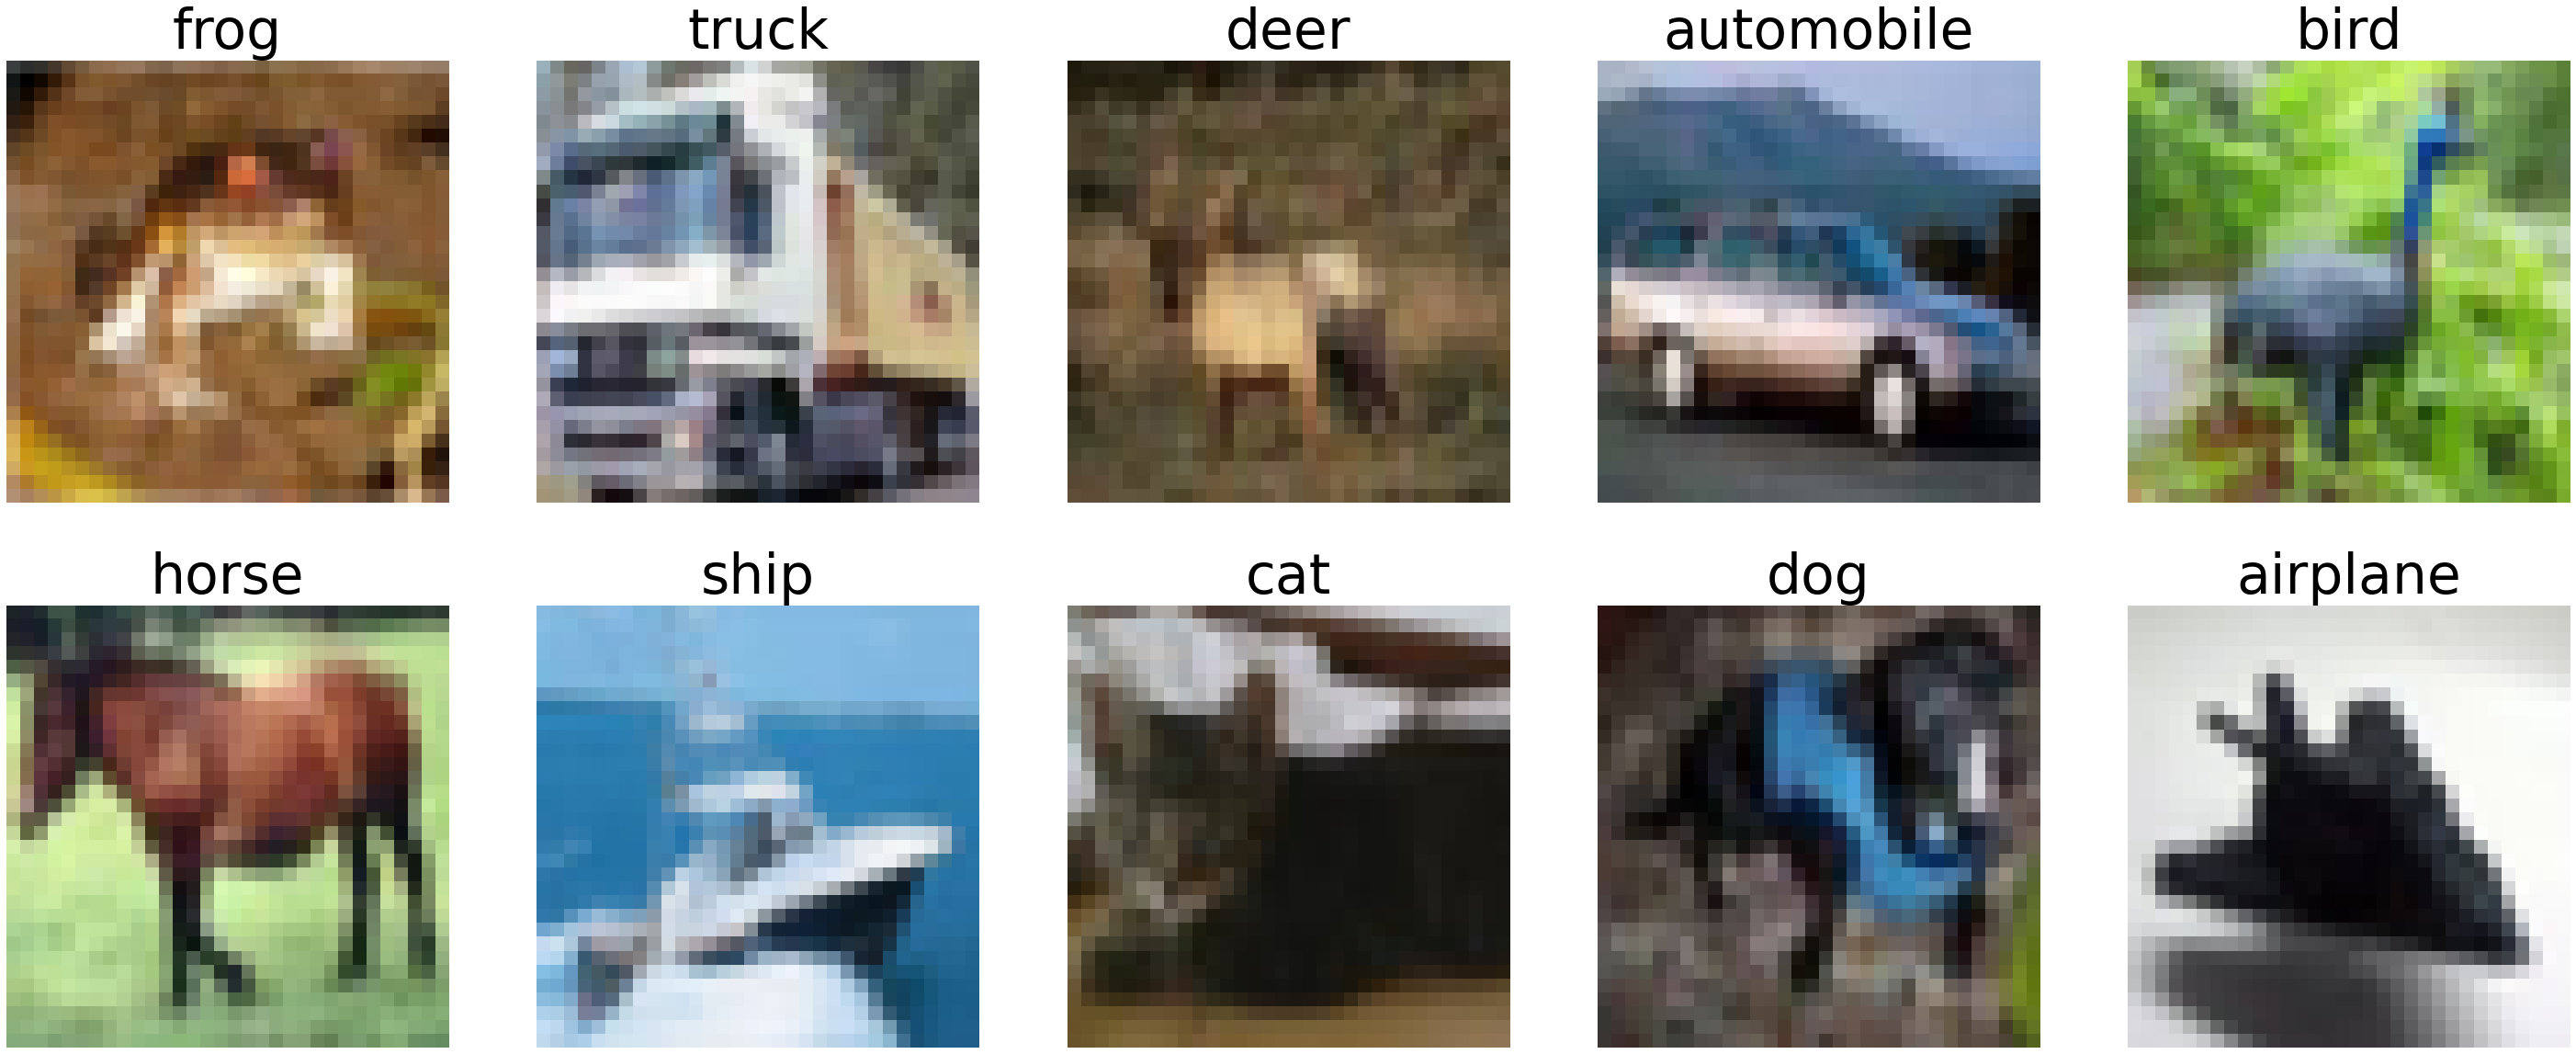

In [4]:
# Get images to display

example_data = datasets.CIFAR10('./datasets', train=True,
                              download=True)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get example image for each class
imgs = {}
for data, target in example_data:
    if target not in imgs.keys():
        imgs[target] = data
        if len(imgs) >= len(classes):
            break
            
from matplotlib.pyplot import figure, imshow, axis

# Display images
fig = plt.figure(figsize=(50, 20))
rows = 2
columns = 5
for i, (key, img) in enumerate(imgs.items()):
    fig.add_subplot(rows, columns, i+1)          
    plt.imshow(img)
    plt.axis('off')
    plt.title(classes[key], fontsize=60)
    
plt.savefig('./plots/cifar10.png', dpi=300, bbox_inches='tight')

# Display corrupted image examples at different severities

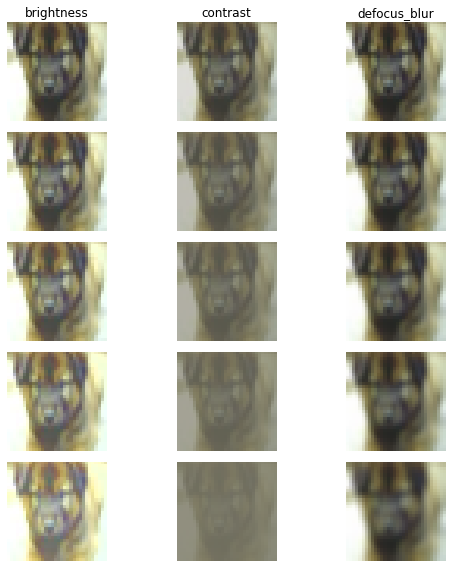

In [5]:
# Display the corrupted images

# specify the corruption categories
CORRUPTIONS = [
    "brightness",
    "contrast",
    "defocus_blur",
]

base_path = "./datasets/CIFAR-10-C/"

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

imgs = []
for corruption in CORRUPTIONS:
    path = base_path + corruption + ".npy"
    data = np.load(path)
    for i in range(33, 50000, 10000):
        imgs.append(data[i]) 
        
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8, 8))

for ax, col in zip(axes[0], CORRUPTIONS):
    ax.set_title(col)

i = 0
for x in range(0, 3):
    for y in range(0, 5):
        axes[y][x].imshow(imgs[i])
        axes[y][x].axis('off')
        i = i+1  
        
fig.tight_layout()
plt.savefig('./plots/cifar10c.png', dpi=300, bbox_inches='tight')
plt.show()

# Prepare test loaders

In [5]:
test_data = datasets.CIFAR10('./datasets', train=False, download=True, transform=transform)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


# Load Base Model

In [6]:
base_model = nets.CIFARModel()
device = utils.get_default_device()
base_model.to(device)
base_model.load_state_dict(torch.load(f"./models/base_cifar.pt"))

<All keys matched successfully>

# Test Base Model

In [7]:
test(base_model, test_loader, device, classes, show_class_accs=True)

  0%|          | 0/157 [00:00<?, ?it/s]

	Accuracy for class: airplane is 81.7 %
	Accuracy for class: automobile is 84.3 %
	Accuracy for class: bird is 54.8 %
	Accuracy for class: cat is 54.7 %
	Accuracy for class: deer is 77.4 %
	Accuracy for class: dog is 43.4 %
	Accuracy for class: frog is 84.5 %
	Accuracy for class: horse is 71.9 %
	Accuracy for class: ship is 82.7 %
	Accuracy for class: truck is 76.8 %


71.22

# Load VSGD Model

In [8]:
from algo.variable_optim import VSGD

vsgd_model = nets.CIFARModel()
vsgd_model.to(device)

vsgd_model.load_state_dict(torch.load("./models/vsgd_cifar_1.0e-02.pt"))
vsgd_model.to(device)
acc = test(vsgd_model, test_loader, device, classes, show_class_accs=True)
print(f"Standard acc: {acc:.2f}")

  0%|          | 0/157 [00:00<?, ?it/s]

	Accuracy for class: airplane is 65.0 %
	Accuracy for class: automobile is 92.3 %
	Accuracy for class: bird is 58.4 %
	Accuracy for class: cat is 50.7 %
	Accuracy for class: deer is 74.6 %
	Accuracy for class: dog is 61.4 %
	Accuracy for class: frog is 74.5 %
	Accuracy for class: horse is 83.6 %
	Accuracy for class: ship is 86.0 %
	Accuracy for class: truck is 71.7 %
Standard acc: 71.82


# Set up corruption datasets

In [9]:
from py.datasets import CIFAR10C

# specify the corruption categories
CORRUPTIONS = [
"brightness",
"contrast",
"defocus_blur",
"elastic_transform",
"fog",
"frost",
"gaussian_noise",
"glass_blur",
"impulse_noise",
"jpeg_compression",
"motion_blur",
"pixelate",
"shot_noise",
"snow",
"zoom_blur"
]

corrupted_cifar_datasets = dict()
for c in CORRUPTIONS:
    dataset = CIFAR10C("./datasets/CIFAR-10-C", c, transform=transform)
    corrupted_cifar_datasets[c] = dataset

# Calculate error on corruption set

In [10]:
from py import ce

base_errors = ce.corruption_errors(base_model, corrupted_cifar_datasets, device)
vsgd_errors = ce.corruption_errors(vsgd_model, corrupted_cifar_datasets, device)

import pprint
print("Base Model errrors:")
pprint.pprint(base_errors)
print("VSGD Model errors:")
pprint.pprint(vsgd_errors)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Base Model errrors:
{'brightness': 32.108,
 'contrast': 57.233999999999995,
 'defocus_blur': 34.449999999999996,
 'elastic_transform': 36.458,
 'fog': 43.242000000000004,
 'frost': 38.946,
 'gaussian_noise': 38.282,
 'glass_blur': 44.812000000000005,
 'impulse_noise': 45.486,
 'jpeg_compression': 30.293999999999997,
 'motion_blur': 40.302,
 'pixelate': 32.248,
 'shot_noise': 36.05,
 'snow': 37.95,
 'zoom_blur': 38.800000000000004}
VSGD Model errors:
{'brightness': 30.747999999999998,
 'contrast': 54.864000000000004,
 'defocus_blur': 36.456,
 'elastic_transform': 36.784,
 'fog': 41.846,
 'frost': 37.907999999999994,
 'gaussian_noise': 36.394,
 'glass_blur': 39.678000000000004,
 'impulse_noise': 41.926,
 'jpeg_compression': 29.944,
 'motion_blur': 42.516,
 'pixelate': 31.546000000000003,
 'shot_noise': 34.721999999999994,
 'snow': 36.502,
 'zoom_blur': 40.778}


# Plot errors on corruption datasets

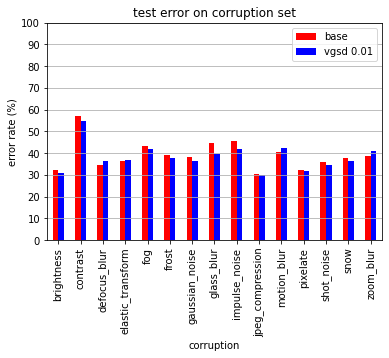

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

d = {
    'base': base_errors,
    'vgsd 0.01': vsgd_errors
}

ax = pd.DataFrame(d).plot(kind='bar', color=['r', 'b'])
plt.ylabel('error rate (%)')
plt.xlabel('corruption')
plt.yticks(np.linspace(0, 100, 11))
plt.grid(axis='y')
plt.title("test error on corruption set")
plt.savefig('./plots/cifar_corruption_errors.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate Corruption Errors (eq 3.1)

Corruption errors:
{'brightness': 95.76429550267846,
 'contrast': 95.85910472795892,
 'defocus_blur': 105.82293178519595,
 'elastic_transform': 100.89417960392781,
 'fog': 96.77165718514405,
 'frost': 97.33477122169157,
 'gaussian_noise': 95.06817825609947,
 'glass_blur': 88.5432473444613,
 'impulse_noise': 92.17341599613069,
 'jpeg_compression': 98.8446557074008,
 'motion_blur': 105.49352389459581,
 'pixelate': 97.82312081369389,
 'shot_noise': 96.31622746185852,
 'snow': 96.18445322793148,
 'zoom_blur': 105.09793814432989}

Mean corruption error: 97.86611339153991


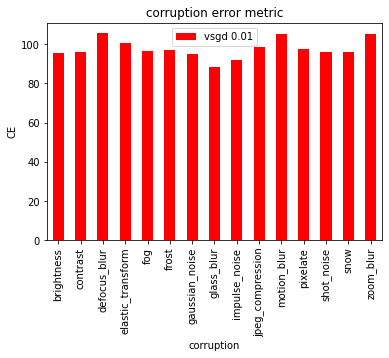

In [12]:
corruption_errors = {k: (vsgd_errors[k]/base_errors[k]) * 100 for k in vsgd_errors.keys() & base_errors}
print("Corruption errors:")
pprint.pprint(corruption_errors)

mce = ce.mean_corruption_error(corruption_errors)
print(f"\nMean corruption error: {mce}")

d = {
    'vsgd 0.01': corruption_errors,
}

pd.DataFrame(d).plot(kind='bar', color=['r', 'b'])
plt.ylabel('CE')
plt.xlabel('corruption')
plt.title("corruption error metric")
plt.savefig('./plots/cifar_corruption_errors2.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate Relative Corruption Errors (eq 3.2)

In [13]:
rce = ce.relative_corruption_error(vsgd_model, base_model, corrupted_cifar_datasets, test_data, device)
print("Relative corruption errors: ")
pprint.pprint(rce)

mrce = ce.mean_corruption_error(rce)
print(f"\nMean relative corruption error: {mrce}")

d = {
    'vsgd 0.01': rce,
}


  0%|          | 0/15 [00:00<?, ?it/s]

Finding relative corruption error for brightness
Finding relative corruption error for contrast
Finding relative corruption error for defocus_blur
Finding relative corruption error for elastic_transform
Finding relative corruption error for fog
Finding relative corruption error for frost
Finding relative corruption error for gaussian_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for impulse_noise
Finding relative corruption error for jpeg_compression
Finding relative corruption error for motion_blur
Finding relative corruption error for pixelate
Finding relative corruption error for shot_noise
Finding relative corruption error for snow
Finding relative corruption error for zoom_blur
Relative corruption errors: 
{'brightness': 77.16346153846158,
 'contrast': 93.77943347156818,
 'defocus_blur': 145.9611992945328,
 'elastic_transform': 112.06043240427196,
 'fog': 94.49592034296774,
 'frost': 95.69152075545935,
 'gaussian_noise': 86.44495895600929

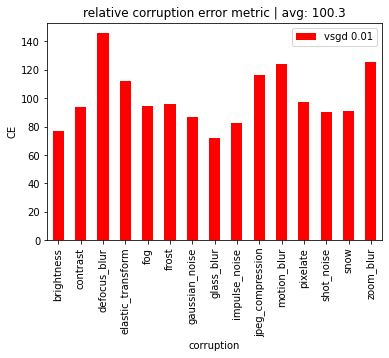

In [14]:
pd.DataFrame(d).plot(kind='bar', color=['r', 'b'])
plt.ylabel('CE')
plt.xlabel('corruption')
plt.title(f"relative corruption error metric | avg: {mrce:.1f}")
plt.savefig('./plots/cifar_relative_corruption_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# Varying the variability

In [16]:
var_file_names = ["1.0e-01", "1.0e-02", "1.5e-03", "2.0e-03", "5.0e-03"]

ces = {}
rces = {}

for var_file in var_file_names:jj
    print(float(var_file))
    vsgd_model = CIFARModel()
    vsgd_model.load_state_dict(torch.load(f"./models/vsgd_cifar_{var_file}.pt"))
    vsgd_errors = ce.corruption_errors(vsgd_model, corrupted_cifar_datasets, device)
    corruption_errors = {k: (vsgd_errors[k]/base_errors[k]) * 100 for k in vsgd_errors.keys() & base_errors}
    rce = ce.relative_corruption_error(vsgd_model, base_model, corrupted_cifar_datasets, test_data, device)
    ces[float(var_file)] = corruption_errors
    rces[float(var_file)] = rce

0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Finding relative corruption error for brightness
Finding relative corruption error for contrast
Finding relative corruption error for defocus_blur
Finding relative corruption error for elastic_transform
Finding relative corruption error for fog
Finding relative corruption error for frost
Finding relative corruption error for gaussian_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for impulse_noise
Finding relative corruption error for jpeg_compression
Finding relative corruption error for motion_blur
Finding relative corruption error for pixelate
Finding relative corruption error for shot_noise
Finding relative corruption error for snow
Finding relative corruption error for zoom_blur
0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Finding relative corruption error for brightness
Finding relative corruption error for contrast
Finding relative corruption error for defocus_blur
Finding relative corruption error for elastic_transform
Finding relative corruption error for fog
Finding relative corruption error for frost
Finding relative corruption error for gaussian_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for impulse_noise
Finding relative corruption error for jpeg_compression
Finding relative corruption error for motion_blur
Finding relative corruption error for pixelate
Finding relative corruption error for shot_noise
Finding relative corruption error for snow
Finding relative corruption error for zoom_blur
0.0015


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Finding relative corruption error for brightness
Finding relative corruption error for contrast
Finding relative corruption error for defocus_blur
Finding relative corruption error for elastic_transform
Finding relative corruption error for fog
Finding relative corruption error for frost
Finding relative corruption error for gaussian_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for impulse_noise
Finding relative corruption error for jpeg_compression
Finding relative corruption error for motion_blur
Finding relative corruption error for pixelate
Finding relative corruption error for shot_noise
Finding relative corruption error for snow
Finding relative corruption error for zoom_blur
0.002


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Finding relative corruption error for brightness
Finding relative corruption error for contrast
Finding relative corruption error for defocus_blur
Finding relative corruption error for elastic_transform
Finding relative corruption error for fog
Finding relative corruption error for frost
Finding relative corruption error for gaussian_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for impulse_noise
Finding relative corruption error for jpeg_compression
Finding relative corruption error for motion_blur
Finding relative corruption error for pixelate
Finding relative corruption error for shot_noise
Finding relative corruption error for snow
Finding relative corruption error for zoom_blur
0.005


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Finding relative corruption error for brightness
Finding relative corruption error for contrast
Finding relative corruption error for defocus_blur
Finding relative corruption error for elastic_transform
Finding relative corruption error for fog
Finding relative corruption error for frost
Finding relative corruption error for gaussian_noise
Finding relative corruption error for glass_blur
Finding relative corruption error for impulse_noise
Finding relative corruption error for jpeg_compression
Finding relative corruption error for motion_blur
Finding relative corruption error for pixelate
Finding relative corruption error for shot_noise
Finding relative corruption error for snow
Finding relative corruption error for zoom_blur


# Display the data

Displaying corruption errors: 
& 280.3& 231.1& 249.7& 261.2& 232.0& 208.1& 297.1& 246.9& 157.2& 235.1& 200.8& 197.9& 223.3& 279.1& 237.2

& 135.9& 128.6& 129.6& 140.1& 134.8& 121.0& 141.5& 135.9& 108.7& 126.1& 115.0& 115.9& 132.1& 136.0& 128.8

& 145.5& 134.1& 130.3& 148.2& 143.0& 131.4& 145.5& 142.8& 114.6& 126.6& 117.1& 115.7& 138.9& 138.2& 130.2

& 133.1& 124.3& 134.1& 135.3& 128.0& 120.1& 143.7& 132.2& 108.6& 129.9& 120.8& 119.6& 127.4& 136.1& 130.7

& 137.8& 127.8& 126.7& 138.3& 133.0& 125.6& 142.9& 135.9& 110.8& 122.7& 114.7& 112.3& 126.5& 135.9& 127.6

Displaying relative corruption errors: 
0.0
& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0& 0.0

93.68605031844388
& 85.3& 76.2& 130.1& 113.2& 79.9& 89.4& 80.7& 67.8& 70.3& 128.8& 110.8& 87.1& 80.8& 86.5& 118.3

96.13327881235197
& 139.8& 81.8& 154.0& 128.8& 98.2& 97.0& 66.8& 60.2& 62.4& 114.3& 115.4& 54.6& 59.5& 79.5& 129.8

77.60018131557898
& 46.9& 69.9& 82.0& 86.5& 69.7& 66.5& 84.4& 75.9& 76.6& 115.3& 7

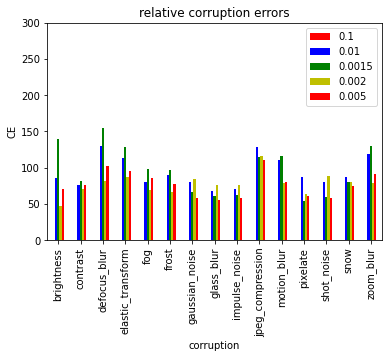

In [17]:
import pprint
import numpy as np
#pprint.pprint(rces)
#pprint.pprint(ces)

print("Displaying corruption errors: ")
for k, v in ces.items():
    for y in v.values():
        print(f"& {y:.1f}", end = '')
    print("\n")
    
print("Displaying relative corruption errors: ")
for k, v in rces.items():

    print(np.mean(list(v.values())))
    for y in v.values():
        print(f"& {y:.1f}", end = '')
    print("\n")
    
pd.DataFrame(rces).plot(kind='bar', color=['r', 'b', 'g', 'y'])
plt.ylabel('CE')
plt.xlabel('corruption')
plt.title(f"relative corruption errors")
plt.ylim(top=300) 
plt.savefig('./plots/cifar_relative_corruption_errors_vars.png', dpi=300, bbox_inches='tight')
plt.show()